In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
from IPython.display import clear_output

In [2]:
X = pd.read_pickle('data/dataset.pkl')
# devide all return by 100 remove percentage sign
X[['ab_capm', 'ab_ff3', 'ab_ff5', 'ex_return']] = X[['ab_capm', 'ab_ff3', 'ab_ff5', 'ex_return']].div(100)
# sign the variables
X[['STreversal', 'Size', 'IdioVol3F', 'IdioRisk', 'PRC', 'BetaFP', 'Beta', 'RoE', 'High52']] = X[['STreversal', 'Size', 'IdioVol3F', 'IdioRisk', 'PRC', 'BetaFP', 'Beta', 'RoE', 'High52']].div(-1)
# format date
X['year_month'] = X['year_month'].astype(str)
X['year_month'] = pd.to_datetime(X['year_month'], format='%Y-%m')

## Univariate Long-short Portfolios with CAPM Abnormal Return

In [3]:
# these 4 variables can not be cut into deciles
['ShareIss1Y', 'ShareRepurchase', 'DelFINL', 'DelLTI']

['ShareIss1Y', 'ShareRepurchase', 'DelFINL', 'DelLTI']

In [4]:
# define a function to build univariate long-short portfolios 
def univariate_long_short(data=X, return_='ab_capm'):
  # long-short portfolios
  long_short = pd.DataFrame()

  variable = ['InvestPPEInv', 'DelCOA', 'dNoa', 'GrLTNOA', 'IntMom', 'LRreversal', 'Mom12m', 'Mom6m', 'MRreversal', 'ResidualMomentum', 'STreversal', 'AM', 'BMdec', 'ChEQ', 'AssetGrowth', 'ChNWC', 'DelEqu', 'NOA', 'Size', 'SP', 'AbnormalAccruals', 'Accruals', 'PctAcc', 'OPLeverage', 'BookLeverage', 'CF', 'cfp', 'DelCOL', 'IdioRisk', 'IdioVol3F', 'Leverage', 'Beta', 'BetaFP', 'BidAskSpread', 'DolVol', 'Illiquidity', 'PRC', 'VolMkt', 'VolSD', 'High52', 'MaxRet', 'CashProd', 'GP', 'roaq', 'RoE']
  
  # full sample 
  for var in variable:
    # based on each variable sort stock into deciles
    data['portfolios_'] = data.groupby('year_month')[var].transform(lambda g: pd.qcut(g, q=10, labels=list(f'Deciles_{i}' for i in range(1,11))))
    # build long-short portfolios each month
    Y = data.groupby(['year_month', 'portfolios_'])[return_].mean().reset_index()
    long = Y[Y['portfolios_']=='Deciles_10']
    short = Y[Y['portfolios_']=='Deciles_1']    
    long_short.index = long['year_month']
    long_short[var] = long[return_].values.reshape(-1,1) - short[return_].values.reshape(-1,1)
    long_short.loc['mean'] = long_short.mean()
    long_short.sort_values(long_short.last_valid_index(), axis=1, ascending=False, inplace=True)
    long_short.drop('mean', axis=0, inplace=True)

  long_short_cum = long_short.cumsum() 
   
  return long_short, long_short_cum

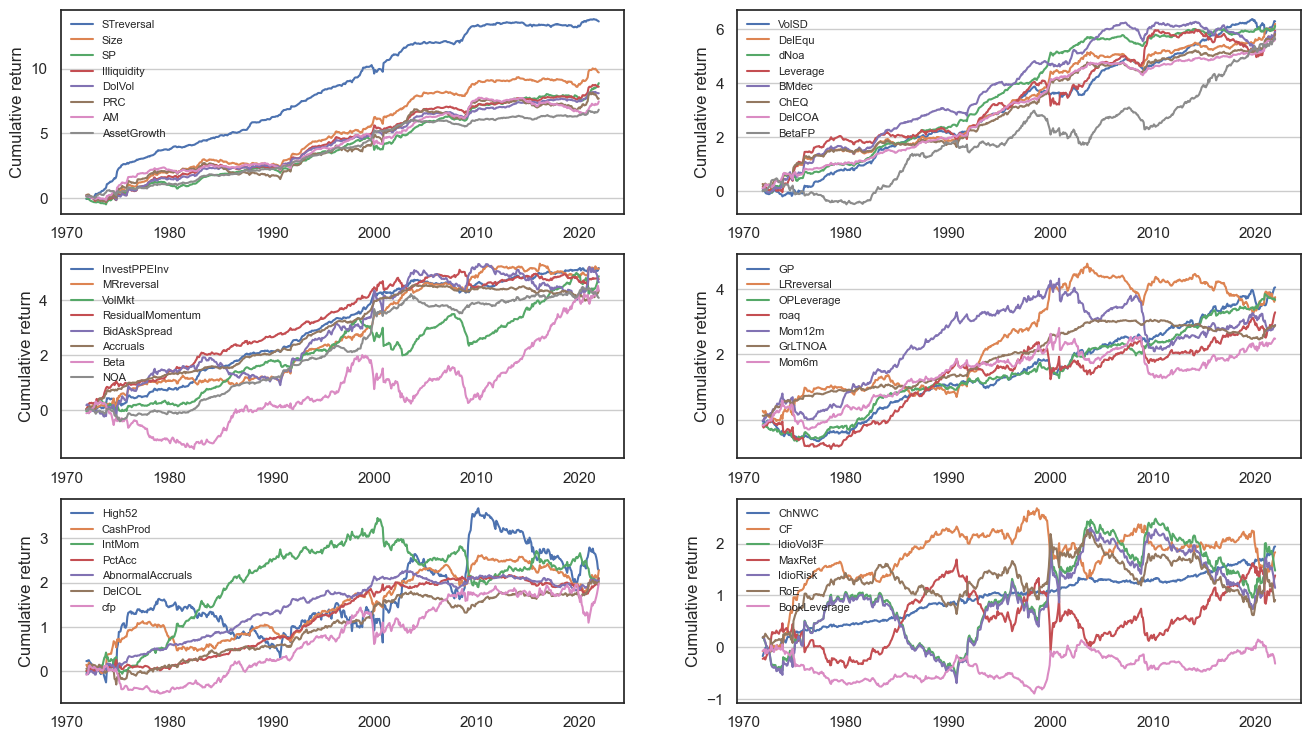

In [5]:
long_short, long_short_cum = univariate_long_short(data=X, return_='ab_capm')

sns.set_theme(font_scale=1, style='white')
fig, axes = pyplot.subplots(3,2,figsize=(16,9))

tidy1 = long_short_cum.iloc[:,:8].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy2 = long_short_cum.iloc[:,8:16].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy3 = long_short_cum.iloc[:,16:24].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy4 = long_short_cum.iloc[:,24:31].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy5 = long_short_cum.iloc[:,31:38].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy6 = long_short_cum.iloc[:,38:45].reset_index().melt(id_vars='year_month').rename(columns=str.title)

sns.lineplot(data=tidy1, x='Year_Month', y='Value', hue='Variable', ax=axes[0, 0])
sns.lineplot(data=tidy2, x='Year_Month', y='Value', hue='Variable', ax=axes[0, 1])
sns.lineplot(data=tidy3, x='Year_Month', y='Value', hue='Variable', ax=axes[1, 0])
sns.lineplot(data=tidy4, x='Year_Month', y='Value', hue='Variable', ax=axes[1, 1])
sns.lineplot(data=tidy5, x='Year_Month', y='Value', hue='Variable', ax=axes[2, 0])
sns.lineplot(data=tidy6, x='Year_Month', y='Value', hue='Variable', ax=axes[2, 1])

for a in range(0,3):
  for b in range(0,2):
    axes[a][b].set(xlabel='', ylabel='Cumulative return', )
    # hide legend title
    handles, labels = axes[a][b].get_legend_handles_labels()
    axes[a][b].legend(handles=handles[0:], labels=labels[0:], loc='upper left', frameon=False, fontsize='8')
    axes[a][b].grid(axis='y')

In [6]:
# define a function to compute mean and sharp ratio for each portfolio
def mean_sr(target='ab_capm', data=X):
  df = pd.DataFrame()
  # full sample
  long_short, _ = univariate_long_short(data=data, return_=target)
  df['mean'] = long_short.mean()
  df['sr'] = long_short.mean()/long_short.std()
  df.sort_values('sr', ascending=False, inplace=True)
  
  # recession period
  data['macro_conditions'] = pd.qcut(data['CFNAI'], 3, labels=False)
  macro_0 = data[data['macro_conditions']==0]
  long_short, _ = univariate_long_short(data=macro_0, return_=target)
  df['mean_recession'] = long_short.mean()
  df['sr_recession'] = long_short.mean()/long_short.std()
  # normal period
  macro_1 = data[data['macro_conditions']==1]
  long_short, _ = univariate_long_short(data=macro_1, return_=target)
  df['mean_normal'] = long_short.mean()
  df['sr_normal'] = long_short.mean()/long_short.std()
  # expansion period
  macro_2 = data[data['macro_conditions']==2]
  long_short, _ = univariate_long_short(data=macro_2, return_=target)
  df['mean_expansion'] = long_short.mean()
  df['sr_expansion'] = long_short.mean()/long_short.std()
  return df

In [7]:
ab_capm = mean_sr(target='ab_capm', data=X)
clear_output()
ab_capm

,mean,sr,mean_recession,sr_recession,mean_normal,sr_normal,mean_expansion,sr_expansion
STreversal,0.022724,0.364174,0.037375,0.484807,0.011997,0.218653,0.017735,0.366835
dNoa,0.010191,0.301665,0.009163,0.257770,0.008353,0.271932,0.012859,0.371783
DelCOA,0.009406,0.288819,0.007771,0.224000,0.007192,0.279330,0.013014,0.366020
VolSD,0.010475,0.270096,0.004682,0.121272,0.013982,0.464993,0.013105,0.291802
Accruals,0.007226,0.268032,0.006112,0.224799,0.004625,0.188486,0.010659,0.373714
AssetGrowth,0.011369,0.257289,0.009316,0.200456,0.012680,0.305398,0.012239,0.276259
InvestPPEInv,0.008594,0.252591,0.007429,0.185262,0.008391,0.303412,0.009935,0.303959
DolVol,0.013492,0.251976,0.010611,0.176176,0.013705,0.319800,0.016168,0.293089
SP,0.014782,0.239440,0.014238,0.192545,0.014259,0.238017,0.015792,0.322558
DelEqu,0.010320,0.232800,0.010544,0.222605,0.008899,0.240782,0.011369,0.240210


In [8]:
# define a function to compare mean and sr across of each portfolios in different macroeconomic conditions

def compare_across_macro(data=ab_capm):
  sr = data[['sr_recession', 'sr_normal', 'sr_expansion']]
  # rank sharpe ratio for each row
  sr1 = sr.rank(axis=1, method='dense').astype(int)
  # count the number ranked in the first, second, and last
  a = ((sr1['sr_recession']==3).sum(), (sr1['sr_normal']==3).sum(), (sr1['sr_expansion']==3).sum())
  b = ((sr1['sr_recession']==2).sum(), (sr1['sr_normal']==2).sum(), (sr1['sr_expansion']==2).sum())
  c = ((sr1['sr_recession']==1).sum(), (sr1['sr_normal']==1).sum(), (sr1['sr_expansion']==1).sum())
  # put into dataframe
  sr2 = pd.DataFrame({'Period': ['Recession','Normal','Expansion'], '1st place': a, '2nd place': b, '3rd place': c})
  # melt for plot
  sr3 = pd.melt(sr2, id_vars='Period', value_vars=['1st place', '2nd place', '3rd place'])
  
  mea = data[['mean_recession', 'mean_normal', 'mean_expansion']]
  # rank mean return for each row
  mea1 = mea.rank(axis=1, method='dense').astype(int)
  # count the number in the first, second, and last
  e = ((mea1['mean_recession']==3).sum(), (mea1['mean_normal']==3).sum(), (mea1['mean_expansion']==3).sum())
  f = ((mea1['mean_recession']==2).sum(), (mea1['mean_normal']==2).sum(), (mea1['mean_expansion']==2).sum())
  g = ((mea1['mean_recession']==1).sum(), (mea1['mean_normal']==1).sum(), (mea1['mean_expansion']==1).sum())
  mea2 = pd.DataFrame({'Period': ['Recession','Normal','Expansion'], '1st place': e, '2nd place': f, '3rd place': g})
  # melt for plot
  mea3 = pd.melt(mea2, id_vars='Period', value_vars=['1st place', '2nd place', '3rd place'])

  return sr3, mea3

c:\Users\wangc\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
c:\Users\wangc\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


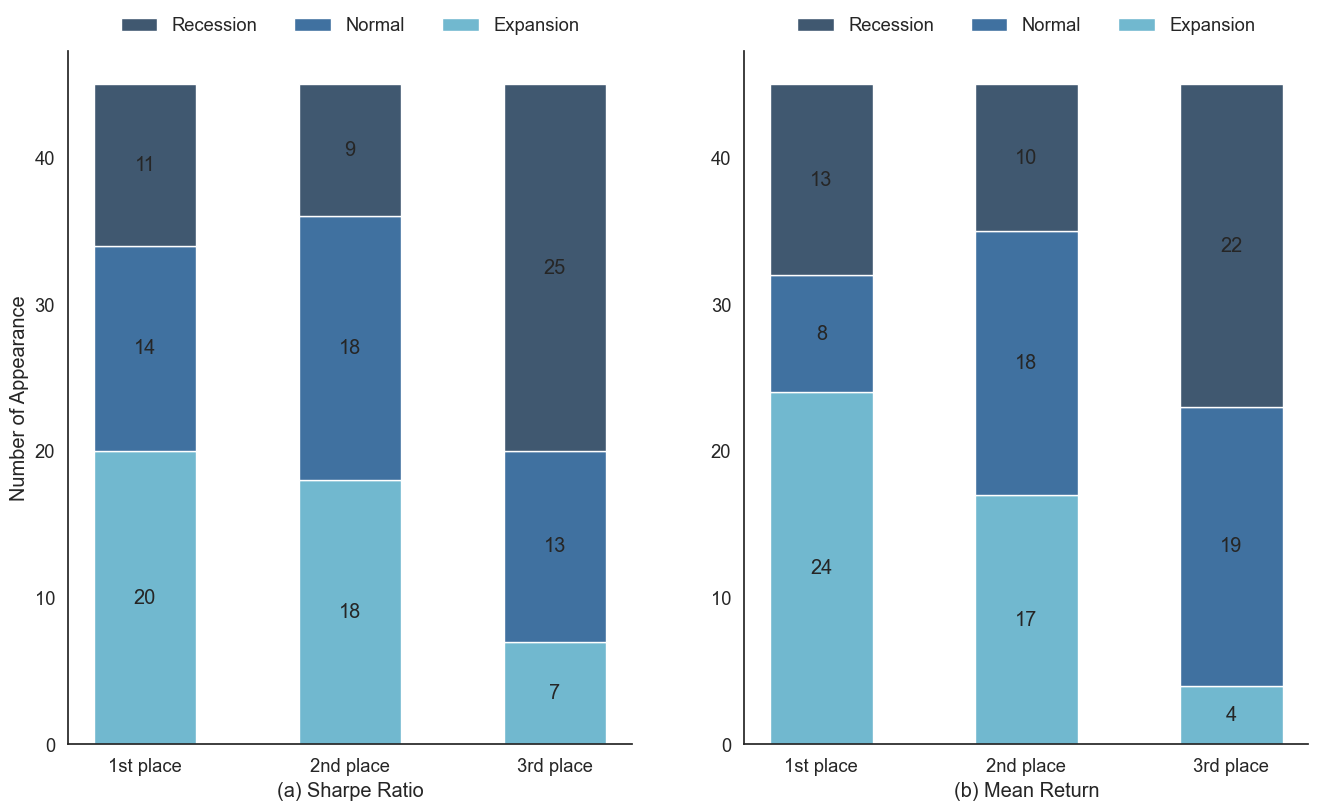

In [9]:
# compare capm abnormal return's mean and sharp ratio in different macroeconomic conditions
capm_sr, capm_mean = compare_across_macro(data=ab_capm)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.2, style='white')

fig, ax = plt.subplots(1,2,figsize=(16,9))

sns.histplot(data=capm_sr, x='variable', weights='value', hue='Period', multiple="stack", shrink=0.5, palette='ocean', ax=ax[0])
sns.histplot(data=capm_mean, x='variable', weights='value', hue='Period', multiple="stack", shrink=0.5, palette='ocean', ax=ax[1])

for a in range(0,2):
  sns.move_legend(ax[a], "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
  for i in ax[a].containers:
    ax[a].bar_label(i, fmt='%d', label_type='center')

ax[0].set_ylabel('Number of Appearance')
ax[1].set_ylabel('')

ax[0].set_xlabel('(a) Sharpe Ratio')
ax[1].set_xlabel('(b) Mean Return')

# remove frame
sns.despine(fig)

## Univariate Long-short Portfolios with FF3 Abnormal Return

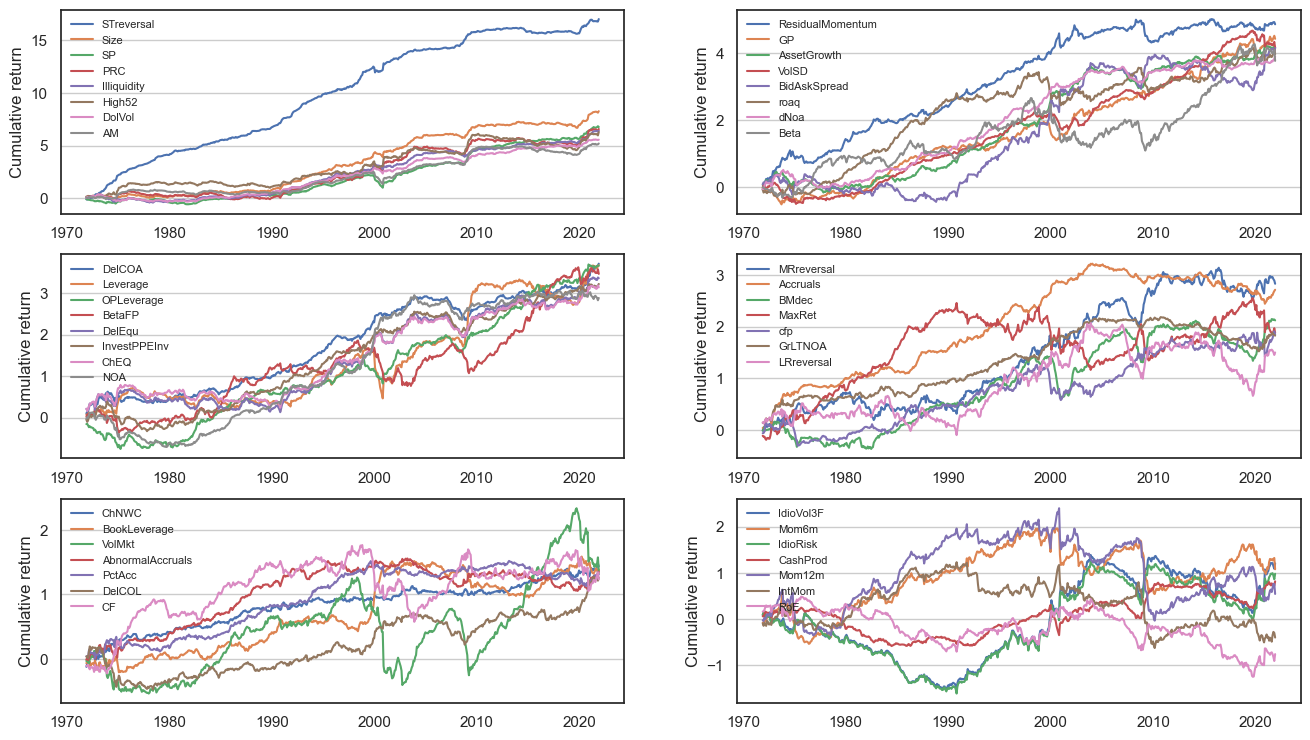

In [10]:
long_short, long_short_cum = univariate_long_short(data=X, return_='ab_ff3')

sns.set_theme(font_scale=1, style='white')
fig, axes = pyplot.subplots(3,2,figsize=(16,9))

tidy1 = long_short_cum.iloc[:,:8].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy2 = long_short_cum.iloc[:,8:16].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy3 = long_short_cum.iloc[:,16:24].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy4 = long_short_cum.iloc[:,24:31].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy5 = long_short_cum.iloc[:,31:38].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy6 = long_short_cum.iloc[:,38:45].reset_index().melt(id_vars='year_month').rename(columns=str.title)

sns.lineplot(data=tidy1, x='Year_Month', y='Value', hue='Variable', ax=axes[0, 0])
sns.lineplot(data=tidy2, x='Year_Month', y='Value', hue='Variable', ax=axes[0, 1])
sns.lineplot(data=tidy3, x='Year_Month', y='Value', hue='Variable', ax=axes[1, 0])
sns.lineplot(data=tidy4, x='Year_Month', y='Value', hue='Variable', ax=axes[1, 1])
sns.lineplot(data=tidy5, x='Year_Month', y='Value', hue='Variable', ax=axes[2, 0])
sns.lineplot(data=tidy6, x='Year_Month', y='Value', hue='Variable', ax=axes[2, 1])

for a in range(0,3):
  for b in range(0,2):
    axes[a][b].set(xlabel='', ylabel='Cumulative return', )
    # hide legend title
    handles, labels = axes[a][b].get_legend_handles_labels()
    axes[a][b].legend(handles=handles[0:], labels=labels[0:], loc='upper left', frameon=False, fontsize='8')
    axes[a][b].grid(axis='y')

In [11]:
ab_ff3 = mean_sr(target='ab_ff3', data=X)
clear_output()
ab_ff3

,mean,sr,mean_recession,sr_recession,mean_normal,sr_normal,mean_expansion,sr_expansion
STreversal,0.028335,0.447251,0.036477,0.468184,0.018308,0.332942,0.029199,0.558500
Size,0.013757,0.238259,0.014047,0.215571,0.012275,0.240993,0.014795,0.265011
SP,0.011259,0.220513,0.012273,0.183899,0.010072,0.235554,0.011313,0.293226
Illiquidity,0.010641,0.218077,0.007951,0.142627,0.011347,0.272978,0.012688,0.267315
DolVol,0.009245,0.215513,0.006280,0.128416,0.009991,0.264472,0.011529,0.282625
dNoa,0.006483,0.209802,0.007045,0.217010,0.003480,0.121361,0.008608,0.276289
DelCOA,0.006177,0.202269,0.005983,0.188984,0.002929,0.119514,0.009275,0.273510
VolSD,0.006919,0.191383,0.001431,0.037473,0.010610,0.354353,0.009079,0.235289
GP,0.007364,0.184488,0.004818,0.118413,0.010823,0.258218,0.006806,0.182962
AssetGrowth,0.006938,0.180913,0.007142,0.172143,0.006510,0.183869,0.007118,0.188265


c:\Users\wangc\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
c:\Users\wangc\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


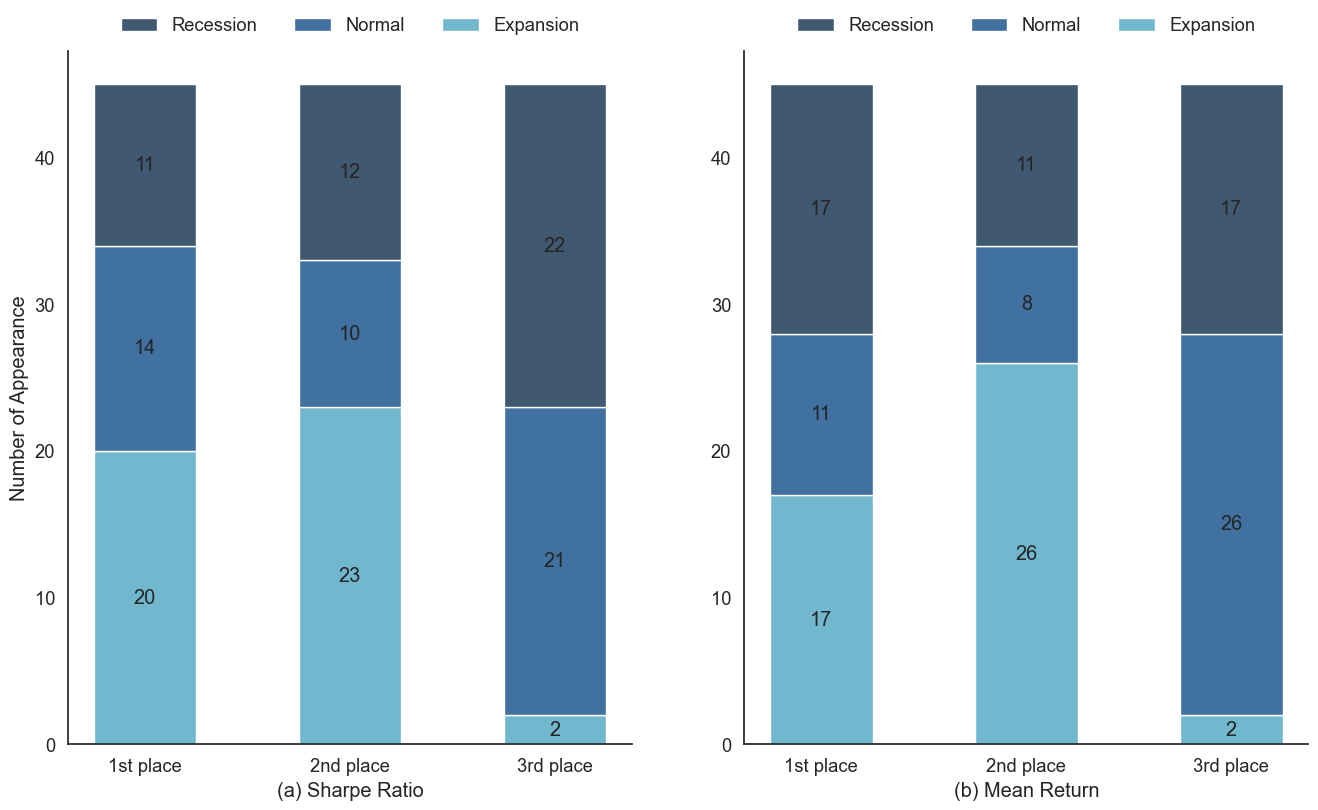

In [12]:
# compare capm abnormal return's mean and sharp ratio in different macroeconomic conditions
capm_sr, capm_mean = compare_across_macro(data=ab_ff3)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.2, style='white')

fig, ax = plt.subplots(1,2,figsize=(16,9))

sns.histplot(data=capm_sr, x='variable', weights='value', hue='Period', multiple="stack", shrink=0.5, palette='ocean', ax=ax[0])
sns.histplot(data=capm_mean, x='variable', weights='value', hue='Period', multiple="stack", shrink=0.5, palette='ocean', ax=ax[1])

for a in range(0,2):
  sns.move_legend(ax[a], "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
  for i in ax[a].containers:
    ax[a].bar_label(i, fmt='%d', label_type='center')

ax[0].set_ylabel('Number of Appearance')
ax[1].set_ylabel('')

ax[0].set_xlabel('(a) Sharpe Ratio')
ax[1].set_xlabel('(b) Mean Return')

# remove frame
sns.despine(fig)

## Univariate Long-short Portfolios with FF5 Abnormal Return

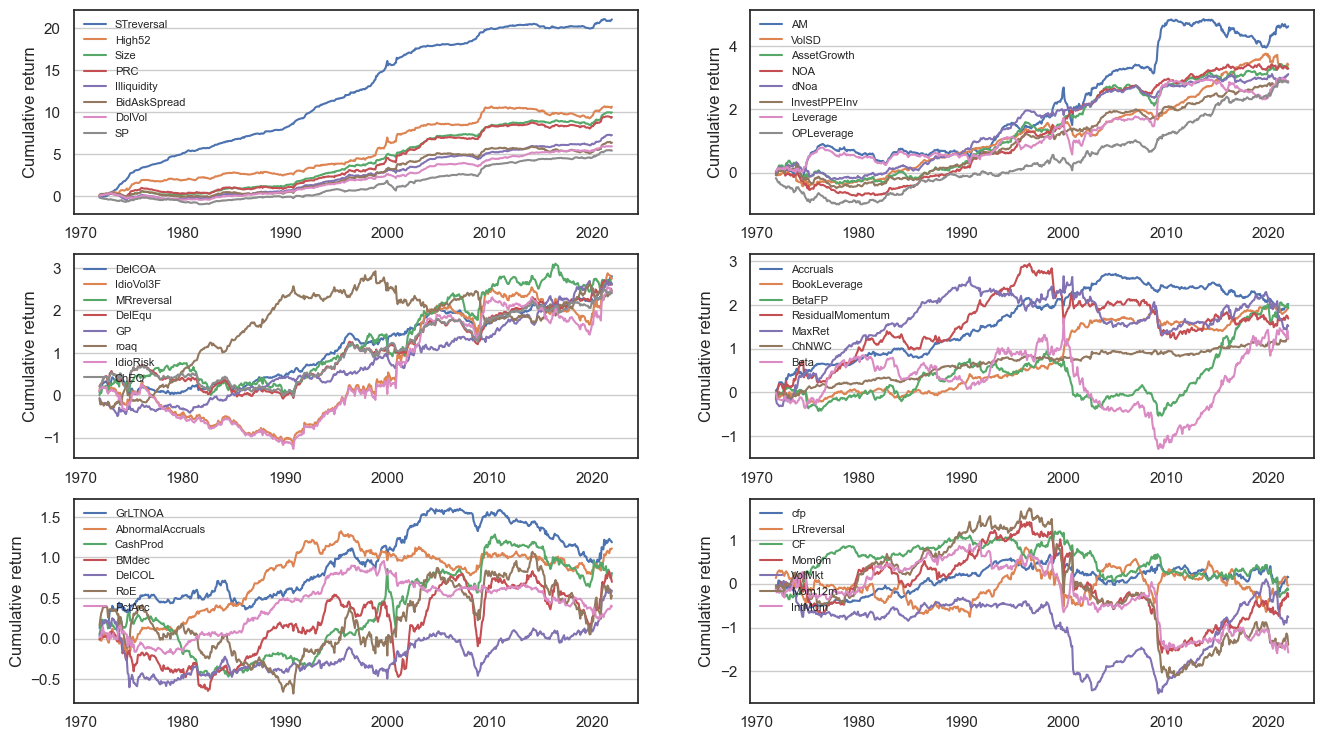

In [13]:
long_short, long_short_cum = univariate_long_short(data=X, return_='ab_ff5')

sns.set_theme(font_scale=1, style='white')
fig, axes = pyplot.subplots(3,2,figsize=(16,9))

tidy1 = long_short_cum.iloc[:,:8].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy2 = long_short_cum.iloc[:,8:16].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy3 = long_short_cum.iloc[:,16:24].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy4 = long_short_cum.iloc[:,24:31].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy5 = long_short_cum.iloc[:,31:38].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy6 = long_short_cum.iloc[:,38:45].reset_index().melt(id_vars='year_month').rename(columns=str.title)

sns.lineplot(data=tidy1, x='Year_Month', y='Value', hue='Variable', ax=axes[0, 0])
sns.lineplot(data=tidy2, x='Year_Month', y='Value', hue='Variable', ax=axes[0, 1])
sns.lineplot(data=tidy3, x='Year_Month', y='Value', hue='Variable', ax=axes[1, 0])
sns.lineplot(data=tidy4, x='Year_Month', y='Value', hue='Variable', ax=axes[1, 1])
sns.lineplot(data=tidy5, x='Year_Month', y='Value', hue='Variable', ax=axes[2, 0])
sns.lineplot(data=tidy6, x='Year_Month', y='Value', hue='Variable', ax=axes[2, 1])

for a in range(0,3):
  for b in range(0,2):
    axes[a][b].set(xlabel='', ylabel='Cumulative return', )
    # hide legend title
    handles, labels = axes[a][b].get_legend_handles_labels()
    axes[a][b].legend(handles=handles[0:], labels=labels[0:], loc='upper left', frameon=False, fontsize='8')
    axes[a][b].grid(axis='y')

In [19]:
ab_ff5 = mean_sr(target='ab_ff5', data=X)
clear_output()
ab_ff5

,mean,sr,mean_recession,sr_recession,mean_normal,sr_normal,mean_expansion,sr_expansion
STreversal,0.034952,0.484004,0.040848,0.499015,0.028620,0.402705,0.034747,0.559081
Size,0.016579,0.283673,0.016886,0.259800,0.014846,0.283410,0.017823,0.313133
Illiquidity,0.012107,0.237178,0.010399,0.174945,0.011955,0.280732,0.013943,0.284041
DolVol,0.009878,0.223650,0.008216,0.164032,0.009721,0.244505,0.011671,0.279920
High52,0.017721,0.214742,0.024255,0.248674,0.010748,0.136327,0.017454,0.256516
PRC,0.015656,0.213407,0.021672,0.253271,0.010286,0.158280,0.014470,0.216310
SP,0.009026,0.173665,0.011091,0.164850,0.008109,0.194963,0.007791,0.185053
BidAskSpread,0.010608,0.163618,0.012944,0.175273,0.005868,0.102697,0.012523,0.202882
NOA,0.005487,0.159195,0.010114,0.255465,0.002050,0.070376,0.003956,0.119760
VolSD,0.005684,0.158640,0.001611,0.037997,0.009588,0.360932,0.006248,0.175193


c:\Users\wangc\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
c:\Users\wangc\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


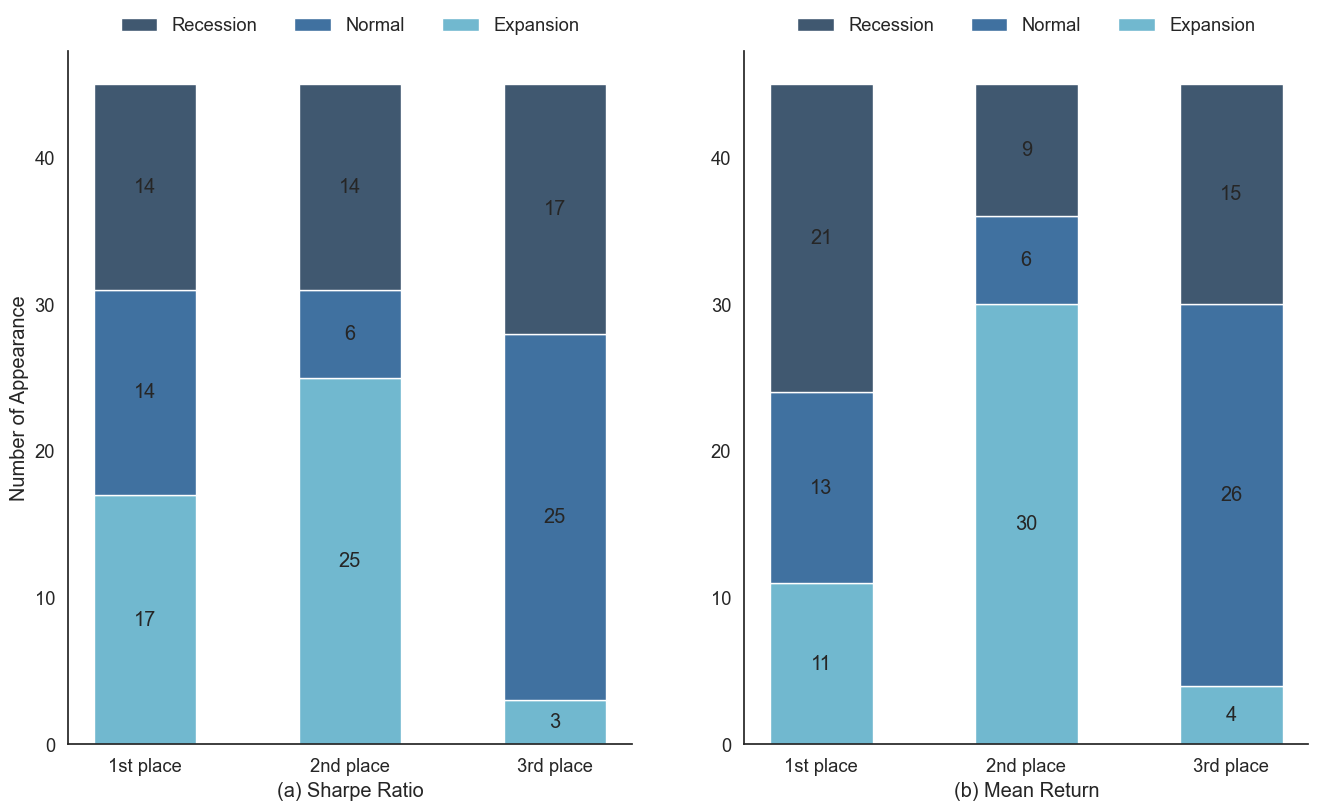

In [15]:
# compare capm abnormal return's mean and sharp ratio in different macroeconomic conditions
capm_sr, capm_mean = compare_across_macro(data=ab_ff5)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.2, style='white')

fig, ax = plt.subplots(1,2,figsize=(16,9))

sns.histplot(data=capm_sr, x='variable', weights='value', hue='Period', multiple="stack", shrink=0.5, palette='ocean', ax=ax[0])
sns.histplot(data=capm_mean, x='variable', weights='value', hue='Period', multiple="stack", shrink=0.5, palette='ocean', ax=ax[1])

for a in range(0,2):
  sns.move_legend(ax[a], "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
  for i in ax[a].containers:
    ax[a].bar_label(i, fmt='%d', label_type='center')

ax[0].set_ylabel('Number of Appearance')
ax[1].set_ylabel('')

ax[0].set_xlabel('(a) Sharpe Ratio')
ax[1].set_xlabel('(b) Mean Return')

# remove frame
sns.despine(fig)

## Univariate Long-short Portfolios with Excess Return

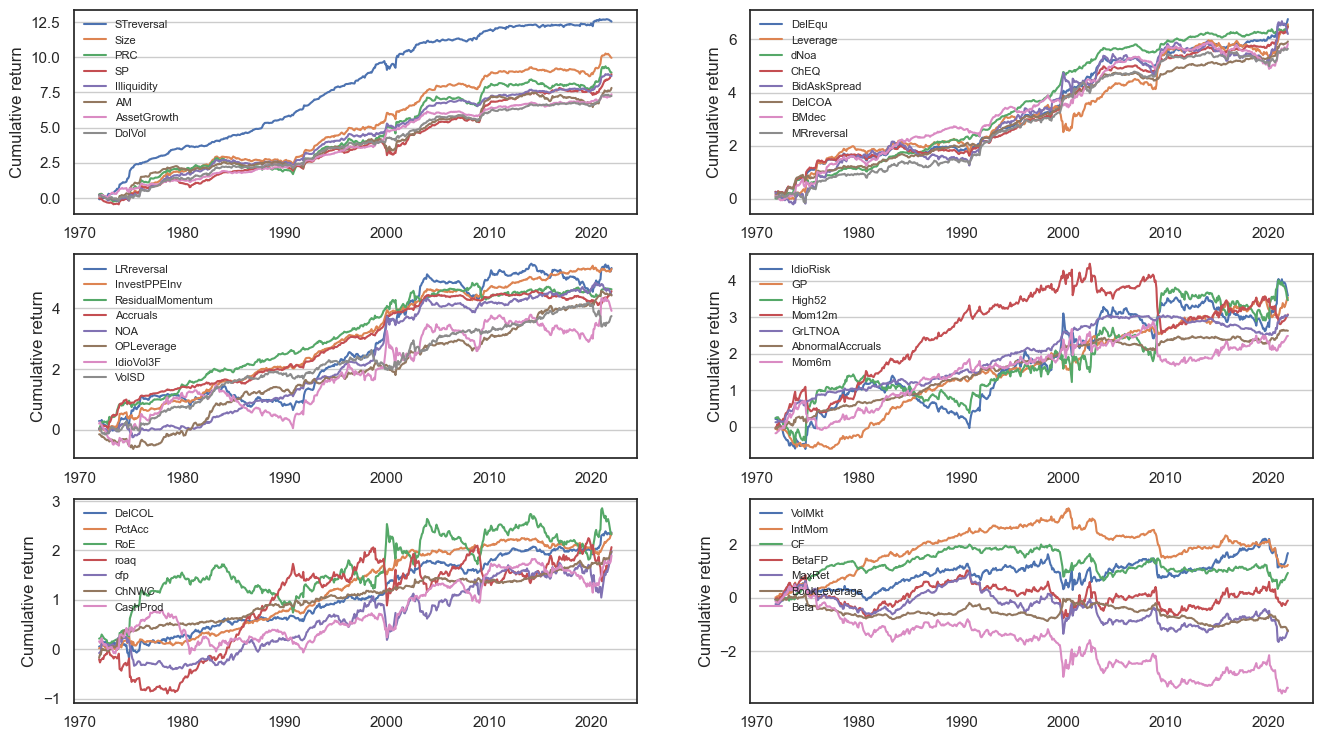

In [16]:
long_short, long_short_cum = univariate_long_short(data=X, return_='ex_return')

sns.set_theme(font_scale=1, style='white')
fig, axes = pyplot.subplots(3,2,figsize=(16,9))

tidy1 = long_short_cum.iloc[:,:8].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy2 = long_short_cum.iloc[:,8:16].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy3 = long_short_cum.iloc[:,16:24].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy4 = long_short_cum.iloc[:,24:31].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy5 = long_short_cum.iloc[:,31:38].reset_index().melt(id_vars='year_month').rename(columns=str.title)
tidy6 = long_short_cum.iloc[:,38:45].reset_index().melt(id_vars='year_month').rename(columns=str.title)

sns.lineplot(data=tidy1, x='Year_Month', y='Value', hue='Variable', ax=axes[0, 0])
sns.lineplot(data=tidy2, x='Year_Month', y='Value', hue='Variable', ax=axes[0, 1])
sns.lineplot(data=tidy3, x='Year_Month', y='Value', hue='Variable', ax=axes[1, 0])
sns.lineplot(data=tidy4, x='Year_Month', y='Value', hue='Variable', ax=axes[1, 1])
sns.lineplot(data=tidy5, x='Year_Month', y='Value', hue='Variable', ax=axes[2, 0])
sns.lineplot(data=tidy6, x='Year_Month', y='Value', hue='Variable', ax=axes[2, 1])

for a in range(0,3):
  for b in range(0,2):
    axes[a][b].set(xlabel='', ylabel='Cumulative return', )
    # hide legend title
    handles, labels = axes[a][b].get_legend_handles_labels()
    axes[a][b].legend(handles=handles[0:], labels=labels[0:], loc='upper left', frameon=False, fontsize='8')
    axes[a][b].grid(axis='y')

In [17]:
ex_return = mean_sr(target='ex_return', data=X)
clear_output()
ex_return

,mean,sr,mean_recession,sr_recession,mean_normal,sr_normal,mean_expansion,sr_expansion
STreversal,0.020855,0.323047,0.033993,0.412146,0.012046,0.217723,0.015656,0.326130
dNoa,0.010801,0.314359,0.009611,0.258551,0.008567,0.282132,0.013983,0.402556
DelCOA,0.009856,0.295631,0.008566,0.245525,0.006874,0.255613,0.013806,0.377343
AssetGrowth,0.012253,0.278037,0.010718,0.231465,0.012882,0.305890,0.013218,0.302698
Accruals,0.007587,0.263720,0.006594,0.220183,0.004238,0.166035,0.011569,0.386279
InvestPPEInv,0.008806,0.256378,0.007474,0.184495,0.008446,0.307610,0.010454,0.314043
DelEqu,0.011258,0.252743,0.011966,0.252577,0.009333,0.243233,0.012275,0.261896
ChEQ,0.010791,0.248982,0.012489,0.261498,0.007865,0.217294,0.011717,0.262515
Size,0.016568,0.232954,0.019445,0.244810,0.013622,0.239114,0.016339,0.220993
Illiquidity,0.014423,0.230930,0.013313,0.195822,0.014120,0.272383,0.015799,0.240874


c:\Users\wangc\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
c:\Users\wangc\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


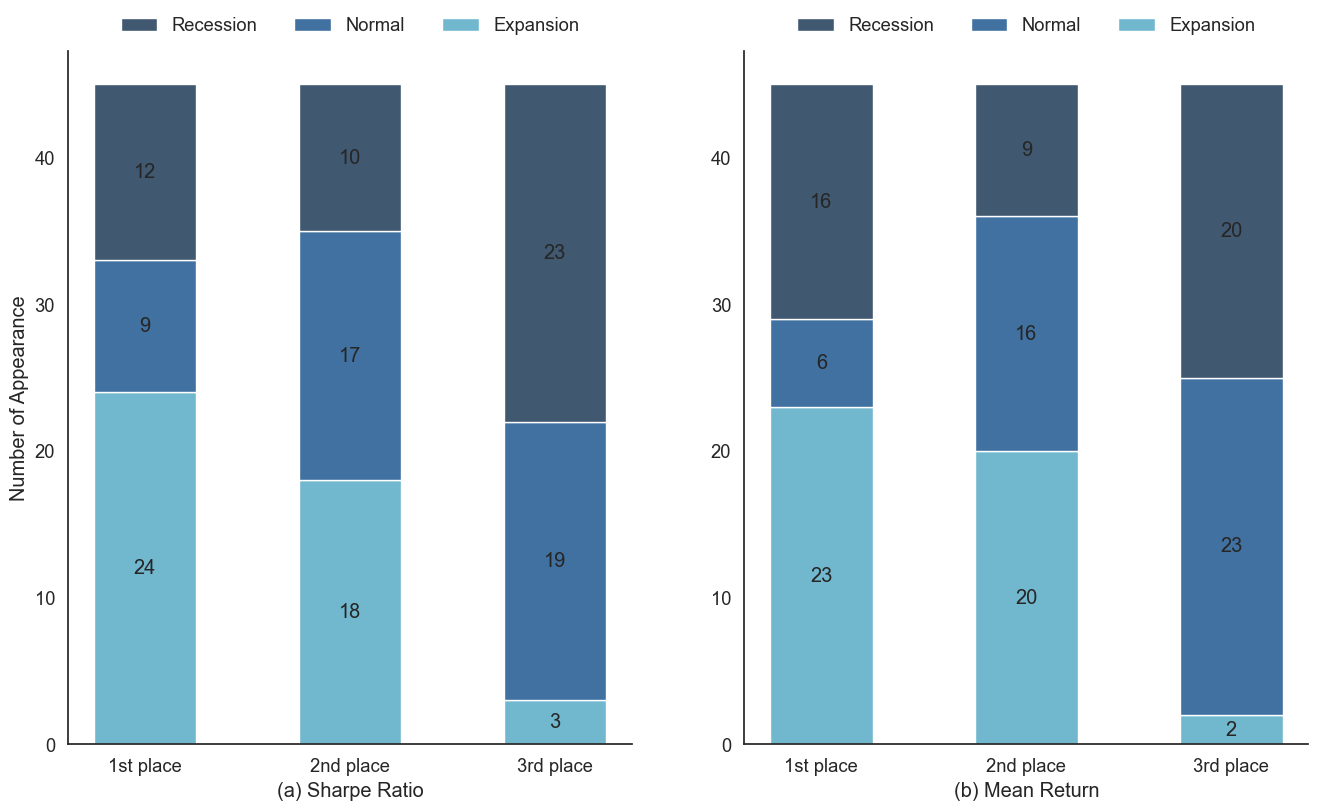

In [18]:
# compare capm abnormal return's mean and sharp ratio in different macroeconomic conditions
capm_sr, capm_mean = compare_across_macro(data=ex_return)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.2, style='white')

fig, ax = plt.subplots(1,2,figsize=(16,9))

sns.histplot(data=capm_sr, x='variable', weights='value', hue='Period', multiple="stack", shrink=0.5, palette='ocean', ax=ax[0])
sns.histplot(data=capm_mean, x='variable', weights='value', hue='Period', multiple="stack", shrink=0.5, palette='ocean', ax=ax[1])

for a in range(0,2):
  sns.move_legend(ax[a], "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
  for i in ax[a].containers:
    ax[a].bar_label(i, fmt='%d', label_type='center')

ax[0].set_ylabel('Number of Appearance')
ax[1].set_ylabel('')

ax[0].set_xlabel('(a) Sharpe Ratio')
ax[1].set_xlabel('(b) Mean Return')

# remove frame
sns.despine(fig)